In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models
from tqdm import tqdm
import os, shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Define the paths
base_dir = 'pdi_labelled_data1'
not_flip_dir = os.path.join(base_dir, 'not_flip')
flipped_dir = os.path.join(base_dir, 'flipped')

# Create the new structure
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(os.path.join(train_dir, 'not_flip'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'flipped'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'not_flip'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'flipped'), exist_ok=True)

# Get the list of files in each folder
not_flip_files = os.listdir(not_flip_dir)
flipped_files = os.listdir(flipped_dir)

# Split the files into train and val
not_flip_train, not_flip_val = train_test_split(not_flip_files, test_size=0.2, random_state=42)
flipped_train, flipped_val = train_test_split(flipped_files, test_size=0.2, random_state=42)

# Move the files to the new structure
for file in not_flip_train:
    shutil.move(os.path.join(not_flip_dir, file), os.path.join(train_dir, 'not_flip', file))

for file in not_flip_val:
    shutil.move(os.path.join(not_flip_dir, file), os.path.join(val_dir, 'not_flip', file))

for file in flipped_train:
    shutil.move(os.path.join(flipped_dir, file), os.path.join(train_dir, 'flipped', file))

for file in flipped_val:
    shutil.move(os.path.join(flipped_dir, file), os.path.join(val_dir, 'flipped', file))

# Remove the old directories
os.rmdir(not_flip_dir)
os.rmdir(flipped_dir)

print("Folder restructuring completed successfully.")

Folder restructuring completed successfully.


In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'pdi_labelled_data1'
image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Load the pretrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to the number of classes.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/lalit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lalit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/lalit/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [14]:
def evaluate_model(model, dataloaders, dataset_sizes):
    model.eval()   # Set model to evaluate mode
    running_corrects = 0

    for inputs, labels in tqdm(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / dataset_sizes['val']
    print(f'Validation Accuracy: {accuracy:.4f}')

In [13]:
import copy
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:37<00:00,  2.09s/it]


train Loss: 0.2574 Acc: 0.8927


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:23<00:00,  1.12it/s]


val Loss: 0.0508 Acc: 0.9808

Epoch 1/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:00<00:00,  1.74s/it]


train Loss: 0.0803 Acc: 0.9747


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:20<00:00,  1.25it/s]


val Loss: 0.0214 Acc: 0.9904

Epoch 2/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:05<00:00,  1.78s/it]


train Loss: 0.0603 Acc: 0.9784


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


val Loss: 0.0176 Acc: 0.9940

Epoch 3/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:04<00:00,  1.78s/it]


train Loss: 0.0454 Acc: 0.9847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.51it/s]


val Loss: 0.0108 Acc: 0.9964

Epoch 4/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:03<00:00,  1.77s/it]


train Loss: 0.0356 Acc: 0.9883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.50it/s]


val Loss: 0.0182 Acc: 0.9952

Epoch 5/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:04<00:00,  1.77s/it]


train Loss: 0.0360 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.52it/s]


val Loss: 0.0125 Acc: 0.9964

Epoch 6/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:07<00:00,  1.80s/it]


train Loss: 0.0378 Acc: 0.9865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.46it/s]


val Loss: 0.0142 Acc: 0.9952

Epoch 7/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [16:13:16<00:00, 561.51s/it]


train Loss: 0.0280 Acc: 0.9898


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.52it/s]


val Loss: 0.0136 Acc: 0.9964

Epoch 8/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:08<00:00,  1.82s/it]


train Loss: 0.0274 Acc: 0.9895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.52it/s]


val Loss: 0.0133 Acc: 0.9964

Epoch 9/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:07<00:00,  1.80s/it]


train Loss: 0.0274 Acc: 0.9913


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.53it/s]


val Loss: 0.0139 Acc: 0.9964

Epoch 10/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:42<00:00,  2.14s/it]


train Loss: 0.0226 Acc: 0.9916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.52it/s]


val Loss: 0.0143 Acc: 0.9964

Epoch 11/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:01<00:00,  1.75s/it]


train Loss: 0.0235 Acc: 0.9931


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:18<00:00,  1.43it/s]


val Loss: 0.0127 Acc: 0.9964

Epoch 12/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [02:57<00:00,  1.70s/it]


train Loss: 0.0229 Acc: 0.9913


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:19<00:00,  1.32it/s]


val Loss: 0.0129 Acc: 0.9964

Epoch 13/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:03<00:00,  1.76s/it]


train Loss: 0.0238 Acc: 0.9916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:18<00:00,  1.43it/s]


val Loss: 0.0134 Acc: 0.9964

Epoch 14/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:16<00:00,  1.89s/it]


train Loss: 0.0210 Acc: 0.9937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.46it/s]


val Loss: 0.0143 Acc: 0.9964

Epoch 15/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:16<00:00,  1.89s/it]


train Loss: 0.0251 Acc: 0.9922


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:18<00:00,  1.44it/s]


val Loss: 0.0135 Acc: 0.9964

Epoch 16/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:11<00:00,  1.84s/it]


train Loss: 0.0204 Acc: 0.9937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.47it/s]


val Loss: 0.0134 Acc: 0.9964

Epoch 17/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:13<00:00,  1.86s/it]


train Loss: 0.0210 Acc: 0.9937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:18<00:00,  1.38it/s]


val Loss: 0.0150 Acc: 0.9964

Epoch 18/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:14<00:00,  1.87s/it]


train Loss: 0.0191 Acc: 0.9940


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.48it/s]


val Loss: 0.0132 Acc: 0.9964

Epoch 19/19
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [03:40<00:00,  2.12s/it]


train Loss: 0.0189 Acc: 0.9943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:25<00:00,  1.04it/s]

val Loss: 0.0132 Acc: 0.9964

Best val Acc: 0.996394


In [15]:
evaluate_model(model_ft, dataloaders, dataset_sizes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:14<00:00,  1.80it/s]

Validation Accuracy: 0.9964


In [21]:
# Save the best model weights
torch.save(model_ft.state_dict(), 'pdi_resnet18.pt')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:14<00:00,  1.77it/s]


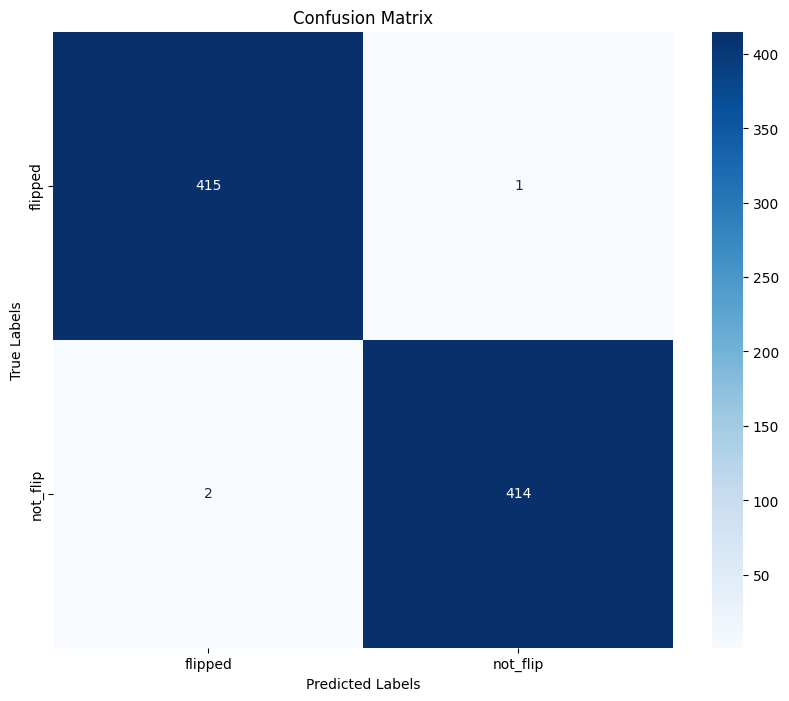

In [19]:
def calculate_confusion_matrix(model, dataloaders, class_names):
    model.eval()  # Set model to evaluate mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return cm
cm = calculate_confusion_matrix(model_ft, dataloaders, class_names)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:13<00:00,  1.91it/s]


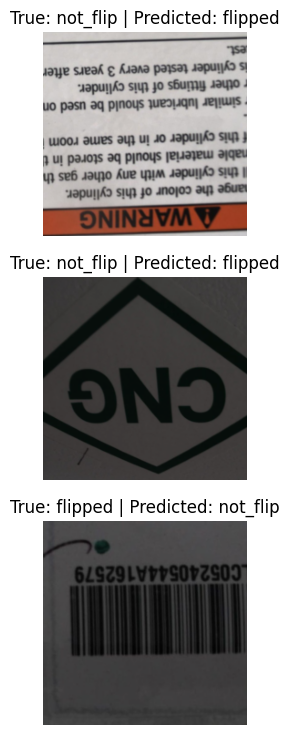

In [20]:
def display_false_predictions(model, dataloaders, class_names, num_images=5):
    model.eval()  # Set model to evaluate mode

    false_images = []
    false_labels = []
    false_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                if preds[i] != labels[i]:
                    false_images.append(inputs[i].cpu())
                    false_labels.append(labels[i].cpu().item())
                    false_preds.append(preds[i].cpu().item())

    # Display the first num_images false predictions
    num_images = min(num_images, len(false_images))
    plt.figure(figsize=(15, num_images * 3))
    for i in range(num_images):
        image = false_images[i]
        true_label = class_names[false_labels[i]]
        predicted_label = class_names[false_preds[i]]

        image = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label} | Predicted: {predicted_label}')
        plt.axis('off')

    plt.show()

# Call the function to display false predictions
display_false_predictions(model_ft, dataloaders, class_names, num_images=3)